In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from autoencoder.autoencoder_standard import AutoencoderStandard
from functions.feature_preprocessing import load_raw_features, save_preprocessed_data

# load raw features and preprocess

In [2]:
bottleneck_dim = 16 # size of the compressed representation
learning_rate = 1e-3

In [3]:
data, features, subject_ids = load_raw_features()
data_scaled = StandardScaler().fit_transform(data)

# pytorch data handling
data_scaled_tensor = torch.tensor(data_scaled, dtype=torch.float32)
dataset = TensorDataset(data_scaled_tensor)
data_loader_torch = DataLoader(dataset, batch_size=32, shuffle=True)
print('batches per epoch:', len(data_loader_torch))


input_dim = data_scaled.shape[1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoencoderStandard(input_dim=input_dim, bottleneck_dim=bottleneck_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(device)

batches per epoch: 19
cpu


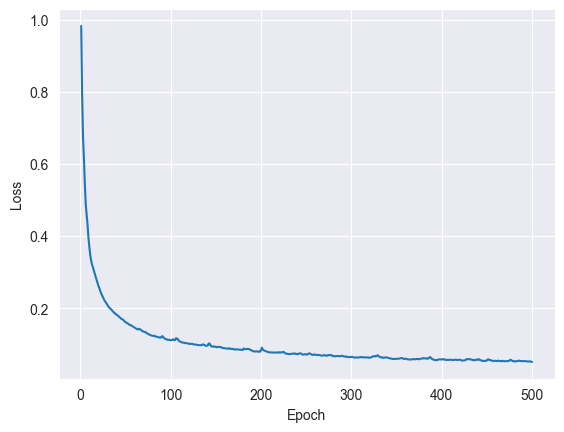

In [4]:
epochs = 500
epoch_losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch in data_loader_torch:
        X_batch = batch[0].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        x_recon, z = model(X_batch)
        loss_value = criterion(x_recon, X_batch)

        # Backward pass and optimization
        loss_value.backward()
        optimizer.step()

        running_loss += loss_value.item() * X_batch.size(0)

    avg_loss = running_loss / len(data_loader_torch.dataset)
    epoch_losses.append(avg_loss)


plt.figure()
plt.plot(range(1, epochs+1), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [5]:
model.eval()
with torch.no_grad():
    X = data_scaled
    X_full = torch.FloatTensor(X).to(device)
    X_recon, Z = model(X_full)

    recon_mse = torch.mean((X_recon - X_full) ** 2).item()
    per_sample_mse = torch.mean((X_recon - X_full) ** 2, dim=1)

    Z_np = Z.cpu().numpy()
    per_sample_mse_np = per_sample_mse.cpu().numpy()

print(f'Overall reconstruction MSE: {recon_mse:.6f}')

Overall reconstruction MSE: 0.048747


In [6]:
latent_cols = [f'latent_{i+1}' for i in range(Z_np.shape[1])]
latent_df = pd.DataFrame(Z_np, columns=latent_cols, index=subject_ids)

save_preprocessed_data(latent_df, output_path='dataset/autoencoder_latent_dim16.csv')


Preprocessed features saved to dataset/autoencoder_latent_dim16.csv



Running KMeans...
  Auto-detecting optimal k using silhouette...
  Optimal k: 2
Internal Validation Metrics:
--------------------------------------------------
  Silhouette Score:         0.1851
    Range: [-1, 1], Higher is better
  Davies-Bouldin Index:     2.1735
    Range: [0, ∞), Lower is better
  Calinski-Harabasz Score:  101.4490
    Range: [0, ∞), Higher is better
  Within-Cluster Variance:  115353.1228
    Lower is better
  Cluster Compactness:
    Cluster 0: 14.6640
    Cluster 1: 11.6681

  Clusters found: 2

Running Agglomerative...
  Auto-detecting optimal n using silhouette...
  Optimal n: 2
Internal Validation Metrics:
--------------------------------------------------
  Silhouette Score:         0.1733
    Range: [-1, 1], Higher is better
  Davies-Bouldin Index:     2.4188
    Range: [0, ∞), Lower is better
  Calinski-Harabasz Score:  84.8215
    Range: [0, ∞), Higher is better
  Within-Cluster Variance:  118162.1110
    Lower is better
  Cluster Compactness:
    Clust

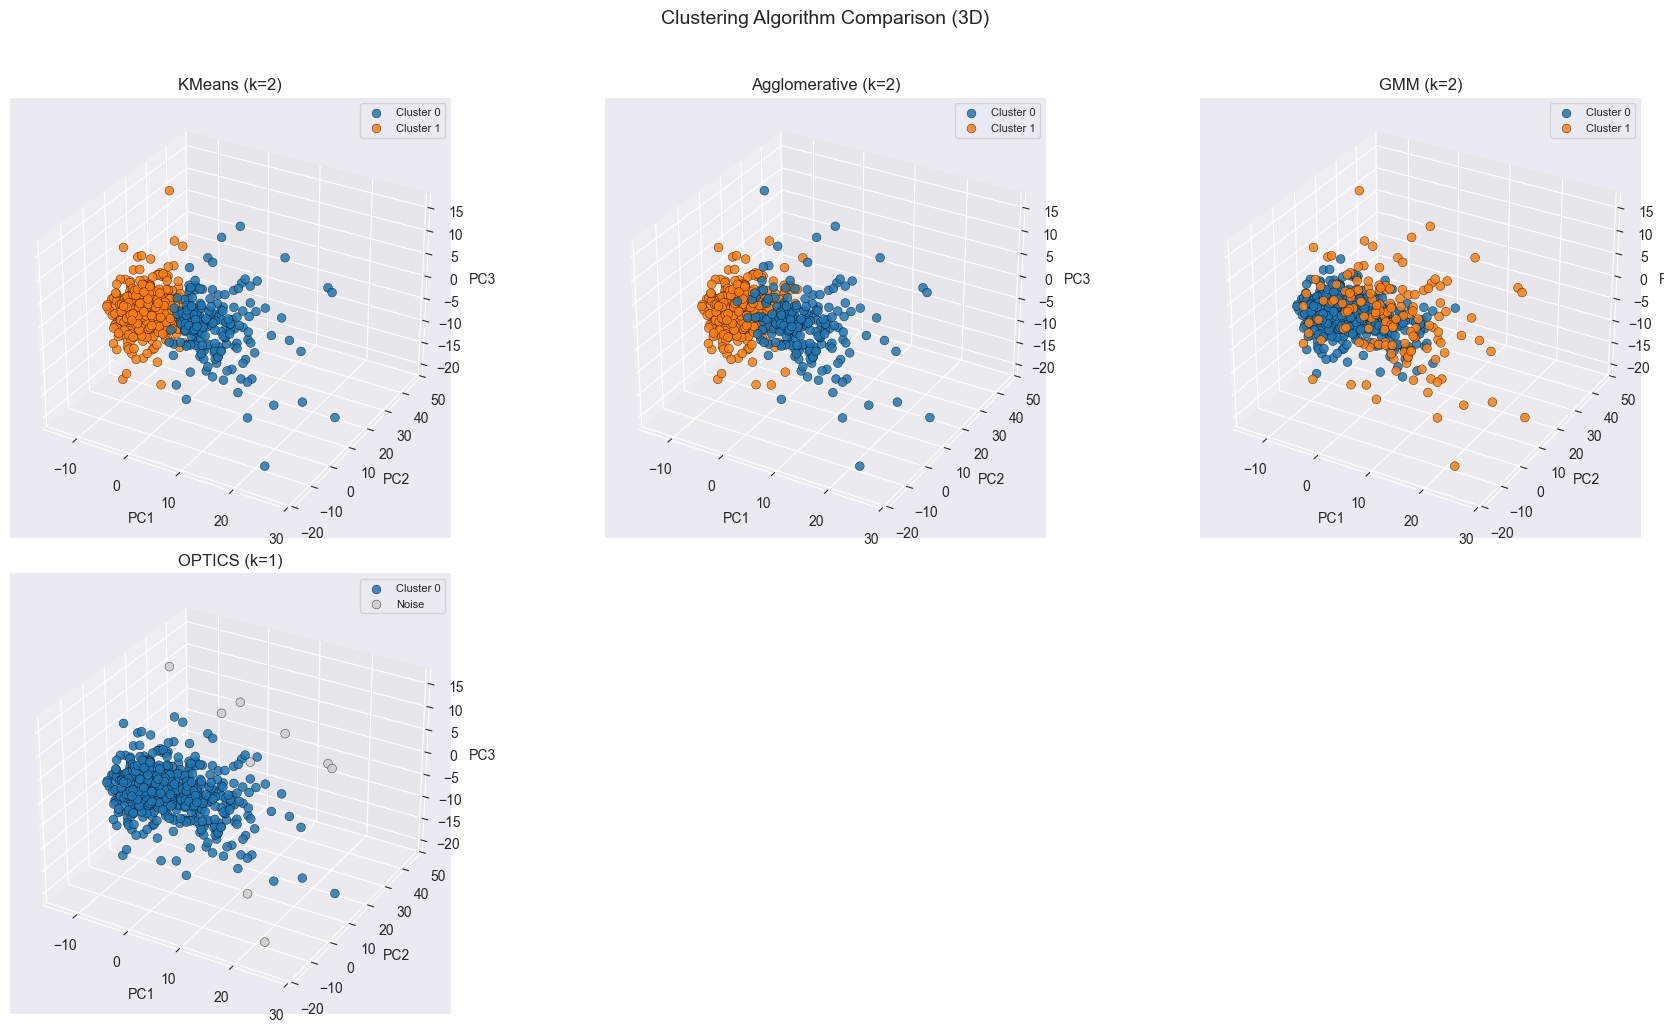

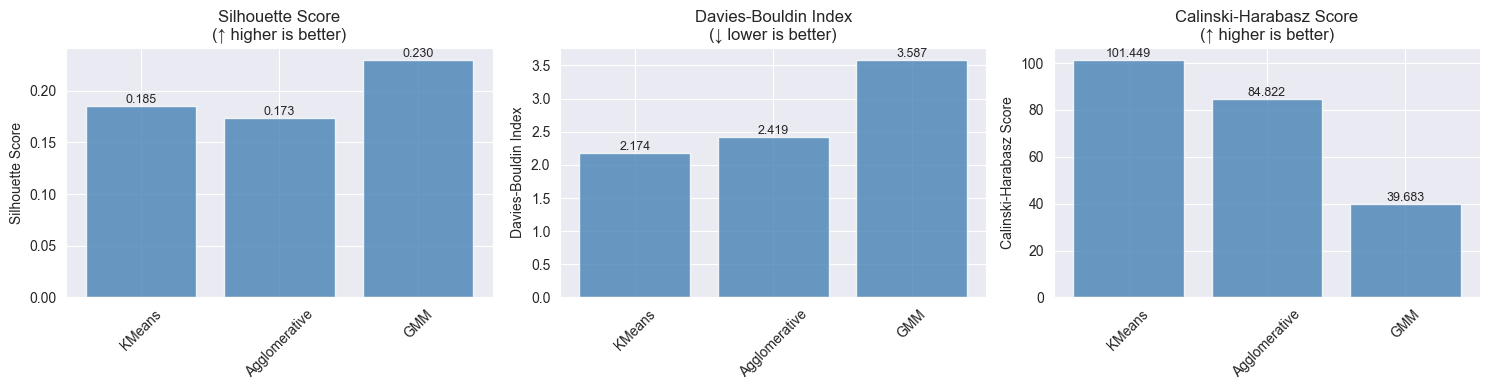

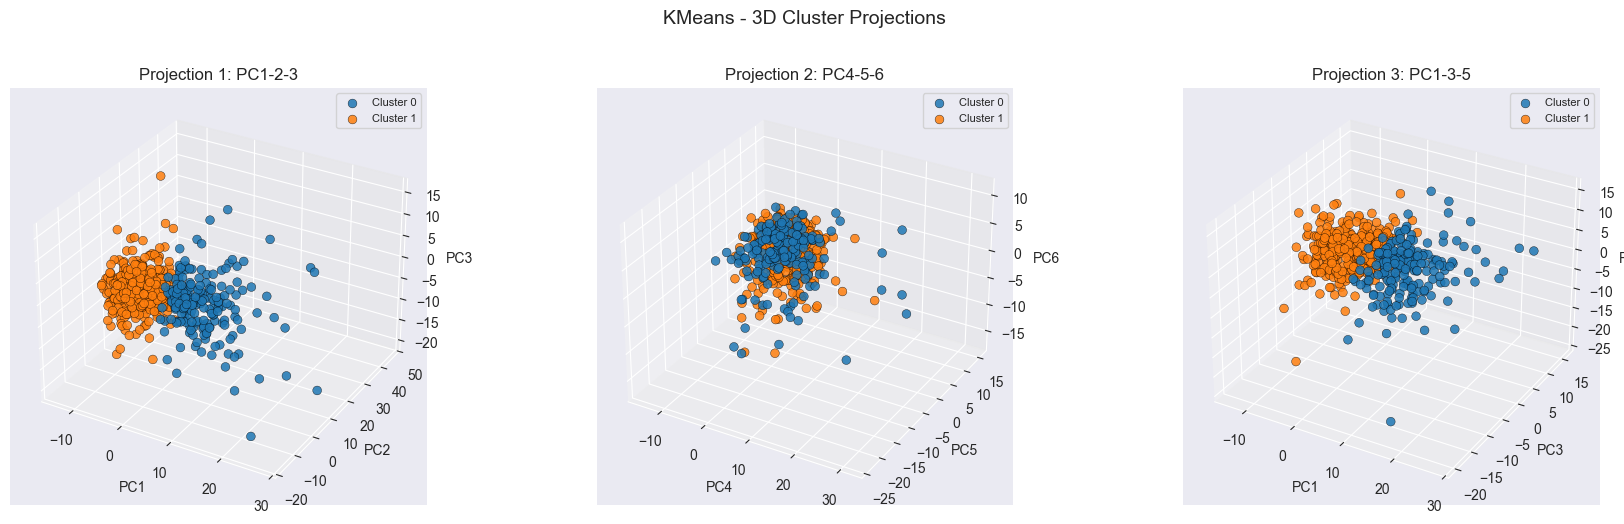

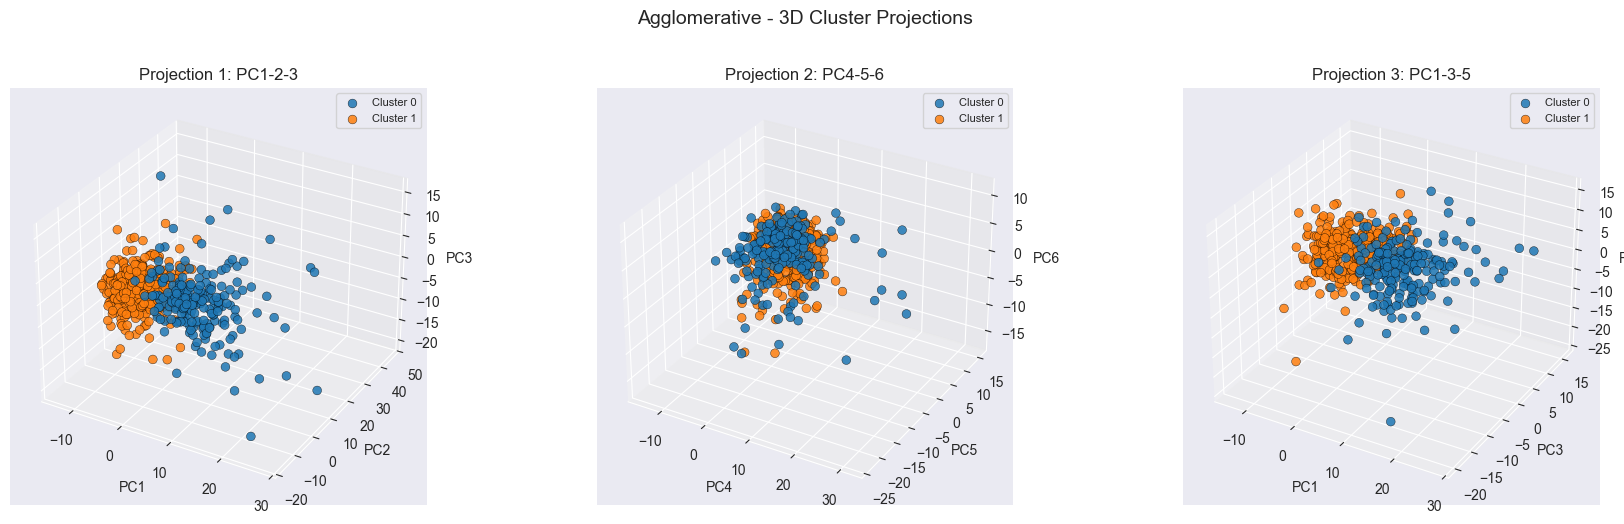

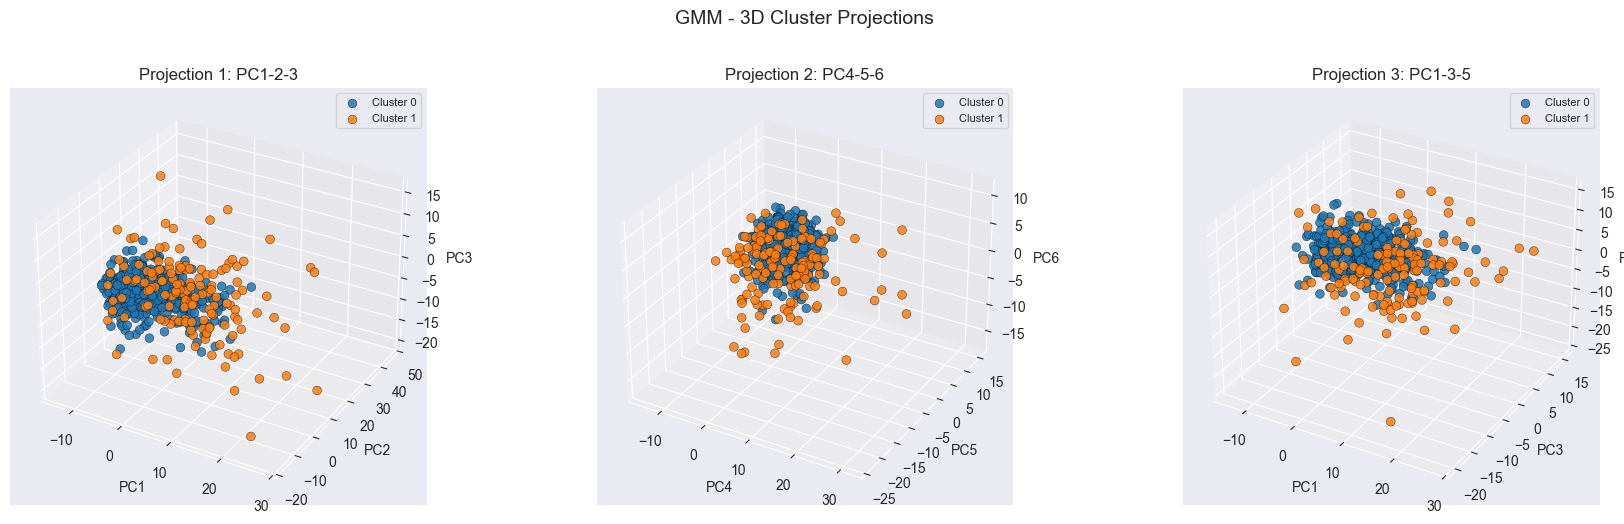

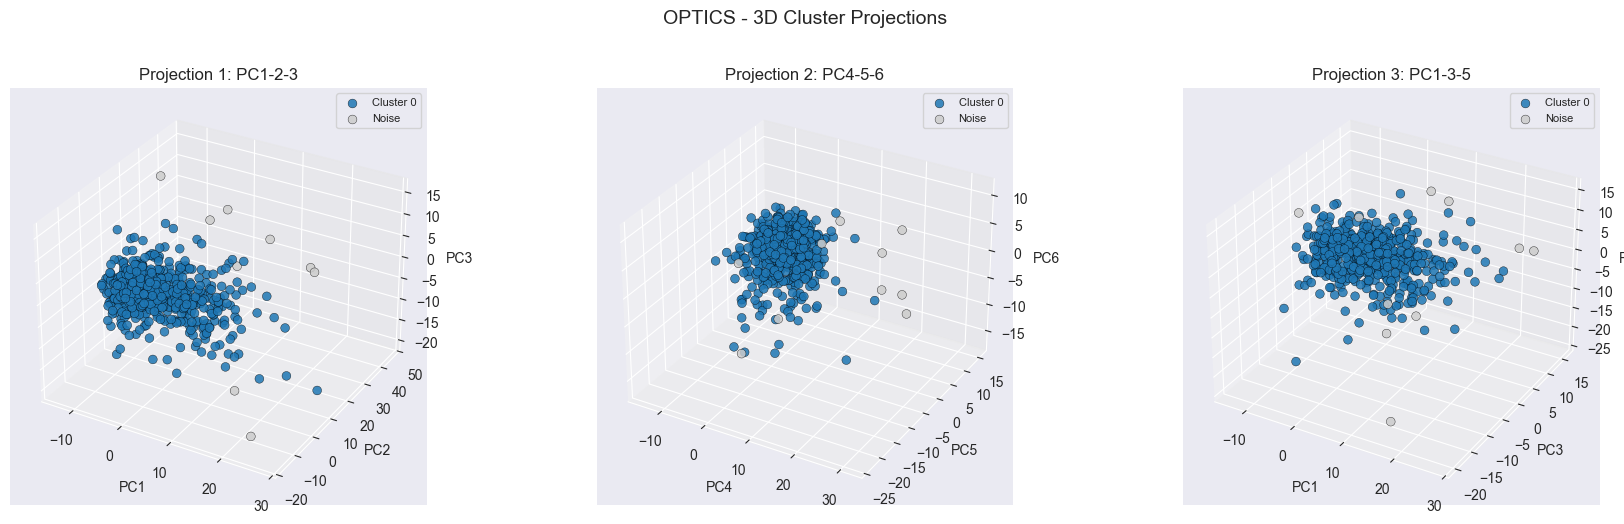


Summary Comparison
       Algorithm  Clusters  Noise Points Silhouette Davies-Bouldin Calinski-Harabasz
0         KMeans         2             0     0.1851         2.1735            101.45
1  Agglomerative         2             0     0.1733         2.4188             84.82
2            GMM         2             0     0.2301         3.5872             39.68
3         OPTICS         1            10        NaN            NaN               NaN


In [7]:
from functions.compare_clusters import CompareConfig, compare_clusters

config = CompareConfig(visualize_3d=True)  # Uses defaults, auto-detects k for all
"""
# Example with custom config:
config = CompareConfig(
    kmeans=ClusterConfig(n_clusters=None, k_range=[2,3,4,5,6], selection_metric='silhouette'),
    gmm=ClusterConfig(n_clusters=None, selection_metric='bic'),
)
"""

results = compare_clusters(Z_np, config=config)


In [12]:
results.keys()

dict_keys(['KMeans', 'Agglomerative', 'GMM', 'OPTICS'])

# External Validation (Age & Sex analysis)

       Epsilon-squared (ε²) = 0.0393 (Small)


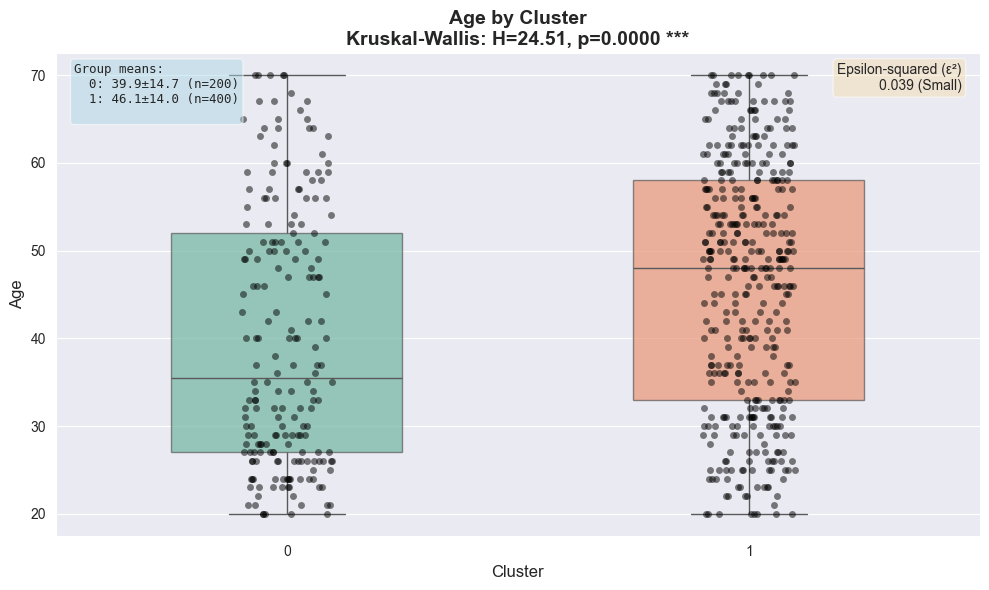


SUMMARY Continuous Variable
Test used: Kruskal-Wallis
Result: SIGNIFICANT (p=0.0000)
Significant pairs: [(np.int64(0), np.int64(1))]
Effect size: Epsilon-squared (ε²) = 0.0393 (Small)


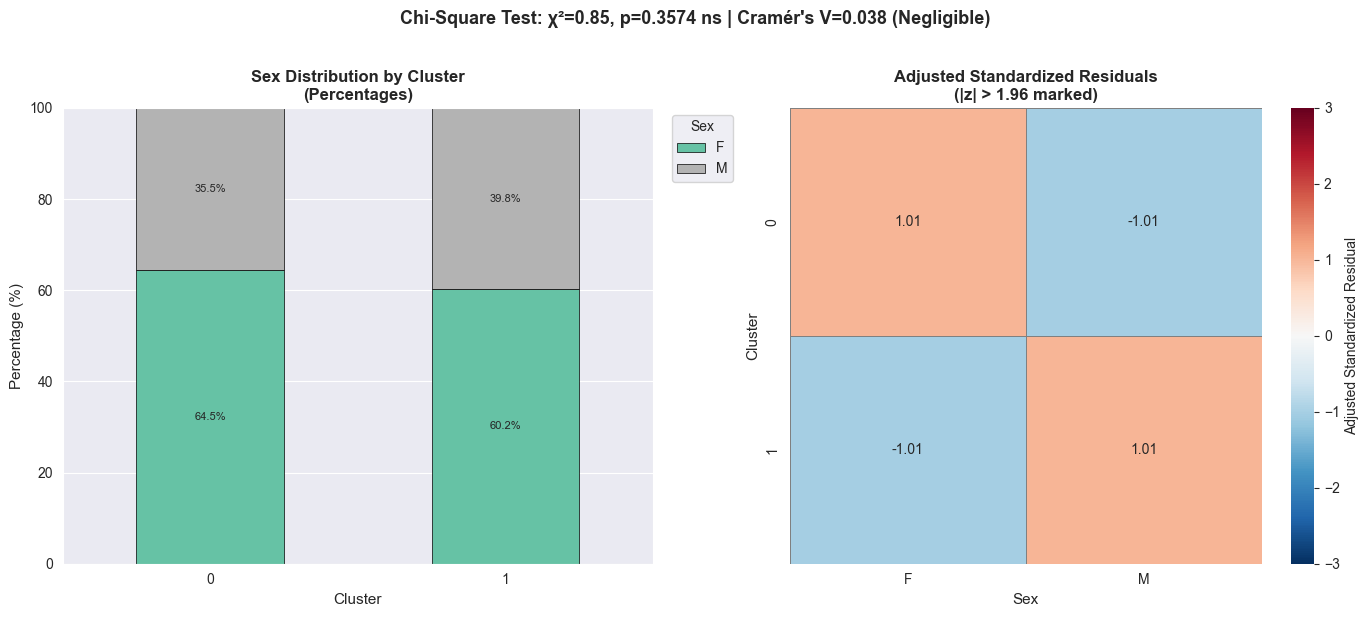


SUMMARY Categorical Analysis
Test used: Chi-Square Test
Result: NOT SIGNIFICANT (p=0.3574)
Effect size: Cramér's V = 0.0376 (Negligible)


In [14]:
from metrics.external_metrics import analyze_continuous_variable, analyze_categorical_variable, load_external_variables

# Load external variables
age, sex = load_external_variables("dataset/Dortmund_age&sex.csv",
                                   subject_ids=subject_ids)

cluster_labels = results['KMeans']['labels']

df_demographics = pd.DataFrame({
    'Cluster': cluster_labels,  # Replace with your best model's labels
    'Age': age,
    'Sex': sex
})

age_result = analyze_continuous_variable(df_demographics, 'Cluster', 'Age')

sex_result = analyze_categorical_variable(df_demographics, 'Cluster', 'Sex')
